<a href="https://colab.research.google.com/github/jphil-16/Airbnb_pricing_model/blob/main/Airbnb_pricing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This model uses Airbnb listing data from [Inside Airbnb](http://insideairbnb.com/) to predict the nightly booking rate for listings in the Seattle area. The following features are used in the model:
*   Number of beds
*   Number of bathrooms
*   Total number of people that can stay
*   Room type (entire home, private room, shared room, etc.)
*   Host response time (within an hour, within a day, etc.)
*   Neighborhood
*   Whether the host is labeled a Superhost
*   Whether the listing can be booked instantly
*   Number of reviews
*   Average number of reviews per month
*   Review rating

The first step in building the model is to import all of the required libraries and load the data (which is stored in a .csv file)

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble, neighbors

import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the data
listings = pd.read_csv('https://raw.githubusercontent.com/jphil-16/Thinkful_Projects_JDP/main/listings.csv')

In [ ]:
# Drop the features that won't be used
listings = listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms',
       'bedrooms', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'])

# Take a quick look at the data
listings.head()

,host_response_time,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,bathrooms_text,beds,price,number_of_reviews,last_review,review_scores_rating,instant_bookable,reviews_per_month
0,within a day,t,Central Area,Entire home/apt,9,2.5 baths,4.0,$295.00,32,2020-02-01,100.0,f,0.22
1,within a few hours,t,Other neighborhoods,Private room,2,3 shared baths,2.0,$55.00,148,2019-12-27,93.0,f,1.19
2,within a day,t,West Seattle,Entire home/apt,4,1 bath,3.0,$155.00,40,2019-12-30,100.0,f,0.37
3,within a day,t,West Seattle,Entire home/apt,3,1 bath,2.0,$125.00,53,2020-08-31,100.0,f,0.50
4,within a few hours,f,Other neighborhoods,Entire home/apt,4,1 bath,4.0,$100.00,97,2020-09-28,91.0,f,0.85


In [ ]:
# See what columns are left
listings.columns

Index(['host_response_time', 'host_is_superhost',
       'neighbourhood_group_cleansed', 'room_type', 'accommodates',
       'bathrooms_text', 'beds', 'price', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'instant_bookable', 'reviews_per_month'],
      dtype='object')

# Data Cleaning
This step has already been started above, by dropping all of the columns that won't be utilized in this model. However, there is still quite a lot to do to prep the data for modeling.

In [ ]:
# First things first - drop the rows that have empty values
# We can afford this step because we will still have thousands of data entires
listings = listings.dropna()
listings.reset_index(drop = True, inplace = True)

In [ ]:
# Next we have to transform columns with text into data that is actually usable

# The listing price needs to be converted from a string to a number
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# The "last review" date needs the first 4 digits extracted to give us the year of the last review
# We will use this to filter out abandoned listings later on
year_last_review = pd.DataFrame([listings.loc[i,'last_review'][:4] for i in range(len(listings))])
year_last_review.columns = ['year_last_review']
listings = pd.concat([listings, year_last_review], axis = 1, sort = False)

# The number of bathrooms is stored as text
# This method of extracting the number treats full baths and half baths as the same
num_baths = pd.DataFrame([listings.loc[i,'bathrooms_text'][:1] for i in range(len(listings))])
num_baths.columns = ['num_baths']
listings = pd.concat([listings, num_baths], axis = 1, sort = False)

In [ ]:
# We still need to transform the bathroom count from a string to an integer
for i in range(len(listings)):
  if listings.loc[i,'num_baths'] == 'H':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i, 'num_baths'] == 'P':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i, 'num_baths'] == 'S':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i,'num_baths'] == '1':
    listings.loc[i, 'num_baths'] = 1
  if listings.loc[i, 'num_baths'] == '2':
    listings.loc[i, 'num_baths'] = 2
  if listings.loc[i, 'num_baths'] == '0':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i,'num_baths'] == '3':
    listings.loc[i, 'num_baths'] = 3
  if listings.loc[i, 'num_baths'] == '4':
    listings.loc[i, 'num_baths'] = 4
  if listings.loc[i, 'num_baths'] == '5':
    listings.loc[i, 'num_baths'] = 5
  if listings.loc[i, 'num_baths'] == '6':
    listings.loc[i, 'num_baths'] = 6
  if listings.loc[i, 'num_baths'] == '7':
    listings.loc[i, 'num_baths'] = 7

In [ ]:
# Next we take all of the features with categorical data and use one-hot encoding
listings = pd.concat([listings,pd.get_dummies(listings.host_is_superhost, prefix="superhost", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.room_type, prefix="room_type", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.neighbourhood_group_cleansed, prefix="neighborhood", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.host_response_time, prefix="response_time", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.instant_bookable, prefix="instant_bookable", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.num_baths, prefix="num_baths", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(listings.host_is_superhost, prefix="superhost", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.room_type, prefix="room_type", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.neighbourhood_group_cleansed, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.host_response_time, prefix="response_time", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.instant_bookable, prefix="instant_bookable", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.num_baths, prefix="num_baths", drop_first=True).columns)

In [ ]:
# Now we need to filter out data that we don't want

# Filter on price first
# Drop rows with expensive listings (We will use $400 as a manual cut-off)
index_names_highprice = listings[listings['price'] > 400 ].index 
listings.drop(index_names_highprice, inplace = True)

# Filter on room type
# Drop rows with hotel rooms (there are very few of these and they are priced very differently)
index_names_hotel = listings[listings['room_type_Hotel room'] == 1 ].index 
listings.drop(index_names_hotel, inplace = True)

# Filter on last review date
# Drop rows with no recent reviews (which represent abandoned listings)
index_names_old = listings[listings['year_last_review'] != '2020' ].index 
listings.drop(index_names_old, inplace = True)

In [ ]:
len(listings)

2478

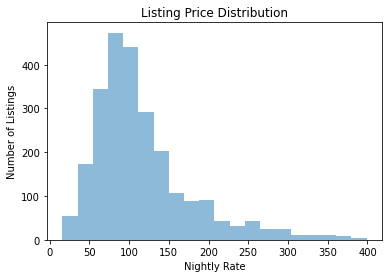

In [ ]:
# Take a quick look at how the target variable is distrubted
plt.hist(listings['price'], alpha = .5, bins = 20)
plt.title('Listing Price Distribution')
plt.xlabel('Nightly Rate')
plt.ylabel('Number of Listings')
plt.show()

In [ ]:
# Let's take another quick look at what our data looks like after all that...
listings.head()

,host_response_time,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,bathrooms_text,beds,price,number_of_reviews,last_review,review_scores_rating,instant_bookable,reviews_per_month,year_last_review,num_baths,superhost_t,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Delridge,neighborhood_Downtown,neighborhood_Interbay,neighborhood_Lake City,neighborhood_Magnolia,neighborhood_Northgate,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_Seward Park,neighborhood_University District,neighborhood_West Seattle,response_time_within a day,response_time_within a few hours,response_time_within an hour,instant_bookable_t,num_baths_1,num_baths_2,num_baths_3,num_baths_4,num_baths_5,num_baths_6
0,within a day,t,Central Area,Entire home/apt,9,2.5 baths,4.0,295.0,32,2020-02-01,100.0,f,0.22,2020,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,within a day,t,West Seattle,Entire home/apt,3,1 bath,2.0,125.0,53,2020-08-31,100.0,f,0.50,2020,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
4,within a few hours,f,Other neighborhoods,Entire home/apt,4,1 bath,4.0,100.0,97,2020-09-28,91.0,f,0.85,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
7,within a few hours,f,Other neighborhoods,Entire home/apt,8,2 baths,3.0,280.0,96,2020-09-27,96.0,f,0.73,2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9,within an hour,t,Downtown,Entire home/apt,6,1 bath,2.0,156.0,105,2020-09-13,94.0,t,0.86,2020,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0


# Build the Model
Now that we have all of our data organized into a usable structure, we need to decide which model type to use. But the first step is to split the data into our features and target variable, and then divide each piece into a training set and a test set.

In [ ]:
# Split the data into X and y
y = listings['price']
X = listings[['number_of_reviews', 'review_scores_rating', 'reviews_per_month','beds', 'accommodates'] + dummy_column_names]
X = sm.add_constant(X)

# Split thae data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 31)

# Get alpha values for the regularization
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [ ]:
# MODEL #1 - LINEAR REGRESSION (OLS)

# Build the model
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Make predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

# Take a look at the results
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     106.8
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:16:07   Log-Likelihood:                -12628.
No. Observations:                2478   AIC:                         2.532e+04
Df Residuals:                    2444   BIC:                         2.552e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -5.8769     20.392     -0.288      0.773     -45.864      34.110
number_of_reviews                    0.0331      0.012      2.705      0.007       0.009       0.057
review_scores_rating                 0.8457      0.131      6.435      0.000       0.588       1.103
reviews_per_month                   -6.1530      0.650     -9.459      0.000      -7.429      -4.877
beds                                 3.9225      1.127      3.481      0.001       1.713       6.132
accommodates                        10.8691      0.694     15.665      0.000       9.509      12.230
superhost_t                          6.6368      1.909      3.477      0.001       2.893      10.380
room_type_Hotel room              5.533e-11   2.57e-11      2.156      0.031       5e-12    1.06e-10
room_type_Private room             -30.6323      2.452    -12.494      0.000     -35.440     -25.825
room_type_Shared room              -53.2712     41.197     -1.293      0.196    -134.056      27.514
neighborhood_Beacon Hill           -17.3544      5.151     -3.369      0.001     -27.456      -7.253
neighborhood_Capitol Hill            9.6951      4.359      2.224      0.026       1.147      18.243
neighborhood_Cascade                12.3264      6.004      2.053      0.040       0.553      24.100
neighborhood_Central Area            1.8783      4.423      0.425      0.671      -6.795      10.552
neighborhood_Delridge              -14.8154      6.001     -2.469      0.014     -26.583      -3.048
neighborhood_Downtown               16.2037      4.009      4.042      0.000       8.343      24.065
neighborhood_Interbay               -6.3544      9.318     -0.682      0.495     -24.627      11.918
neighborhood_Lake City             -10.5712      7.045     -1.501      0.134     -24.386       3.244
neighborhood_Magnolia               15.9260      6.641      2.398      0.017       2.903      28.949
neighborhood_Northgate             -20.5665      6.117     -3.362      0.001     -32.561      -8.572
neighborhood_Other neighborhoods     1.0654      3.844      0.277      0.782      -6.473       8.604
neighborhood_Queen Anne             22.1415      4.536      4.881      0.000      13.246      31.037
neighborhood_Rainier Valley        -14.8747      4.842     -3.072      0.002     -24.370      -5.379
neighborhood_Seward Park            -6.5739      7.833     -0.839      0.401     -21.935       8.787
neighborhood_University District     8.0979      5.974      1.356      0.175      -3.616      19.812
neighborhood_West Seattle            4.9974      4.497      1.111      0.267      -3.820      13.815
response_time_within a day           7.8213     10.561      0.741      0.459     -12.889      28.532
response_time_within a few hours    -3.1628     10.29

In [ ]:
# Cross Validation
ols_scores = cross_val_score(lrm, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', ols_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(ols_scores)))

Accuracy scores for the 5 folds:  [0.46585472 0.60972723 0.51582174 0.59379702 0.54736492]
Mean cross validation score: 0.547


In [ ]:
# MODEL #2 - K-NEAREST NEIGHBORS

# Build the model
knn = neighbors.KNeighborsRegressor(n_neighbors=7)
knn.fit(X, y)

# Take a look at the results
knn_7_score = knn.score(X_test, y_test)

In [ ]:
# Cross validation
knn_score = cross_val_score(knn, X, y, cv=7)

print('Accuracy scores for the 7 folds: ', knn_score)
print('Mean cross validation score: {:.3f}'.format(np.mean(knn_score)))

Accuracy scores for the 7 folds:  [0.23152435 0.32394255 0.29211397 0.43307547 0.33986997 0.45925494
 0.40837988]
Mean cross validation score: 0.355


In [ ]:
# MODEL #3 - GRADIENT BOOSTING

# Build the model
params = {'n_estimators': 200,
          'max_depth': 2,
          'loss': 'ls',
          'learning_rate': 0.13,
          'subsample': 0.95,
          'min_samples_split': 3,
          'min_samples_leaf': 2}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

# Make predictions
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Take a look at the accuracy
clf.score(X_test, y_test)

0.6941183192088318

In [ ]:
# MODEL #4 - RANDOM FOREST

# Build the model
rfc = ensemble.RandomForestRegressor()
scores_total = cross_val_score(rfc, X, y, cv=10)

# Take a look the scores
np.mean(scores_total)

0.5671028949585999

# Using the model
Now we have some results! After tuning each model, it looks like the gradient boosting model performed the best. There is definitely some room for improvement (see the associated presentation for more details about how we can improve the model) but for now let's use this model to take a look at some real data.

Say we have a 1-bedroom apartment in the Queen Anne neighbordhood of Seattle and we want to list it on Airbnb. What should we set the nightly price to? We can look at two seperate cases for comparison: a new listing with only a few mediocre, and an established Superhost listing with a large number of very good reviews. We will assume that the apartment has 1 bathroom and can host 3 people (2 in the bedroom and 1 extra person in the living room).

In [ ]:
# Define the test data
test_airbnb_data = {'const': [1, 1], 'number_of_reviews': [3, 186],'review_scores_rating': [90.0, 100.0],
                    'reviews_per_month': [1.5, 1.5],'beds': [1, 1],'accommodates': [3, 3],'superhost_t': [0, 1],
                    'room_type_Hotel room': [0, 0],'room_type_Private room': [0, 0],'room_type_Shared room': [0, 0],
                    'neighborhood_Beacon Hill': [0, 0],'neighborhood_Capitol Hill': [0, 0],'neighborhood_Cascade': [0, 0],
                    'neighborhood_Central Area': [0, 0],'neighborhood_Delridge': [0, 0],'neighborhood_Downtown': [0, 0],
                    'neighborhood_Interbay': [0, 0],'neighborhood_Lake City': [0, 0],'neighborhood_Magnolia': [0, 0],
                    'neighborhood_Northgate': [0, 0],'neighborhood_Other neighborhoods': [0, 0],'neighborhood_Queen Anne': [1, 1],
                    'neighborhood_Rainier Valley': [0, 0],'neighborhood_Seward Park': [0, 0],'neighborhood_University District': [0, 0],
                    'neighborhood_West Seattle': [0, 0],'response_time_within a day': [0, 0],'response_time_within a few hours': [0, 0],
                    'response_time_within an hour': [1, 1],'instant_bookable_t': [1, 1],'num_baths_1': [1, 1],'num_baths_2': [0, 0],
                    'num_baths_3': [0, 0],'num_baths_4': [0, 0],'num_baths_5': [0, 0],'num_baths_6': [0, 0]
                    }

test_columns = ['const', 'number_of_reviews', 'review_scores_rating',
       'reviews_per_month', 'beds', 'accommodates', 'superhost_t',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'neighborhood_Beacon Hill',
       'neighborhood_Capitol Hill', 'neighborhood_Cascade',
       'neighborhood_Central Area', 'neighborhood_Delridge',
       'neighborhood_Downtown', 'neighborhood_Interbay',
       'neighborhood_Lake City', 'neighborhood_Magnolia',
       'neighborhood_Northgate', 'neighborhood_Other neighborhoods',
       'neighborhood_Queen Anne', 'neighborhood_Rainier Valley',
       'neighborhood_Seward Park', 'neighborhood_University District',
       'neighborhood_West Seattle', 'response_time_within a day',
       'response_time_within a few hours', 'response_time_within an hour',
       'instant_bookable_t', 'num_baths_1', 'num_baths_2', 'num_baths_3',
       'num_baths_4', 'num_baths_5', 'num_baths_6']

# Turn it into a dataframe for use in the model
test_df = pd.DataFrame(test_airbnb_data, columns = test_columns)

# Take a quick look
test_df

,const,number_of_reviews,review_scores_rating,reviews_per_month,beds,accommodates,superhost_t,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Delridge,neighborhood_Downtown,neighborhood_Interbay,neighborhood_Lake City,neighborhood_Magnolia,neighborhood_Northgate,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_Seward Park,neighborhood_University District,neighborhood_West Seattle,response_time_within a day,response_time_within a few hours,response_time_within an hour,instant_bookable_t,num_baths_1,num_baths_2,num_baths_3,num_baths_4,num_baths_5,num_baths_6
0,1,3,90.0,1.5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1,1,186,100.0,1.5,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0


In [ ]:
# Now - make the predictions!
predict_real = clf.predict(test_df)
predict_real

array([105.7182792 , 135.07462338])

# Results
There you have it - as a new listing, we should price the apartment at 105 dollars per night, but as we build up reviews over time we can increase the price by 30 dollars per night.